## Content Based Image Retrieval System

We have make use of transfer learning, approximate nearest neighbors oh yeah , and embeddings centroid detection in PyTorch to build our recommender.




1. Ankit Singh   :  IEC2018076
2. Shakti Majhwar: IEC2018006
3. Achal Singhal : IEC2018023
4. Rishab        : IEC2018049





# Initial Setup

In [ ]:
# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy
!pip install gdown

     |████████████████████████████████| 646 kB 5.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391622 sha256=406dbeaef9ffe9736c3e8b830bcbc82a8a2a786f3677b3210cd00119918b7c47
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
#importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
import random
%matplotlib inline


In [ ]:
# Checking if GPU is active
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
# else:
#     print('CUDA is available!  Training on GPU ...')
#     print(gpu_info)

## load Data

DeepFashion data set: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

We are using v1 of the data, with 280K+ images. 

In [ ]:
# get the meta data
url = 'https://drive.google.com/uc?id=1BcTS3Bh4_o09locSRw6qIBnCxJItMgK-'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1SqlgrTWRm_jiId2ILsgkyQ8jIR-3p7Jk'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1pcHNkLcoA7tw8a9zJ6beRiqYB0YvQWxj'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1BcTS3Bh4_o09locSRw6qIBnCxJItMgK-
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SqlgrTWRm_jiId2ILsgkyQ8jIR-3p7Jk
To: /content/list_category_img.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 94.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pcHNkLcoA7tw8a9zJ6beRiqYB0YvQWxj
To: /content/list_eval_partition.txt
100%|██████████| 22.2M/22.2M [00:00<00:00, 107MB/s] 


'list_eval_partition.txt'

In [ ]:
# get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
100%|██████████| 2.68G/2.68G [00:33<00:00, 80.5MB/s]


In [ ]:
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


In [ ]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head(10)

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,val,Blouse
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,test,Blouse
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,train,Blouse
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,train,Blouse
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,train,Blouse


In [ ]:
len(data_df)

289222

In [ ]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [ ]:
len(data_df.category.unique())

46

In [ ]:
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


# Convert images to embeddings

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


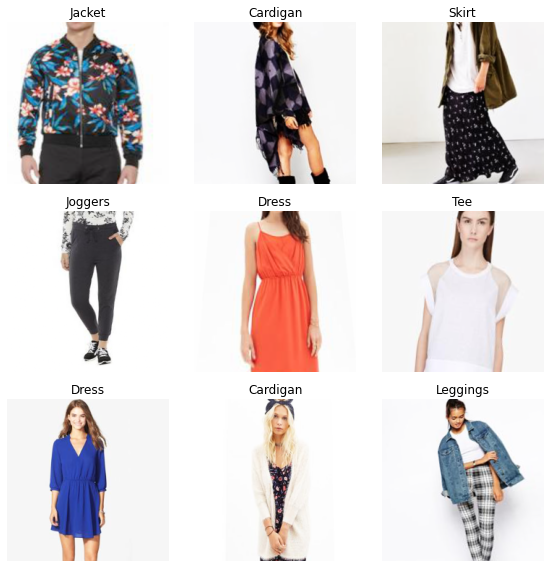

In [ ]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from ResNet

## Resnet50 (Commented)


In [ ]:
# def train_model(data, pretrained_model, model_metrics):
#     learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
#     learner.model = torch.nn.DataParallel(learner.model)
#     learner.lr_find()
#     learner.recorder.plot(suggestion=True)
#     return learner

# pretrained_model = models.resnet50 


# model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# learner = train_model(data, pretrained_model, model_metrics)

In [ ]:
# learner.fit_one_cycle(8, max_lr=1e-02)

## Evaluate Model 

In [ ]:
# interp = ClassificationInterpretation.from_learner(learner)
# interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

In [ ]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# saving the model (temporary, will lose model once environment resets)
# learner.save('resnet-fashion')

In [ ]:
# saving the model (permanent), need to enter authorization code
# drive.mount('/content/gdrive')
# learner.save('/content/gdrive/My Drive/resnet50-fashion')

In [ ]:
# view model details
# learner.model.module

# Use Fastai hooks to retrieve image embeddings

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet18

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
drive.mount('/content/gdrive') 

url = 'https://drive.google.com/uc?id=1o-Ln9Cy-pvJuPbEg0M0FNyrdZg8XpWBp'
output = 'resnet18-fashion.pth'
gdown.download(url, output, quiet=False)

model_path = "/content/resnet18-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

Mounted at /content/gdrive


Downloading...
From: https://drive.google.com/uc?id=1o-Ln9Cy-pvJuPbEg0M0FNyrdZg8XpWBp
To: /content/resnet18-fashion.pth
100%|██████████| 51.5M/51.5M [00:00<00:00, 143MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

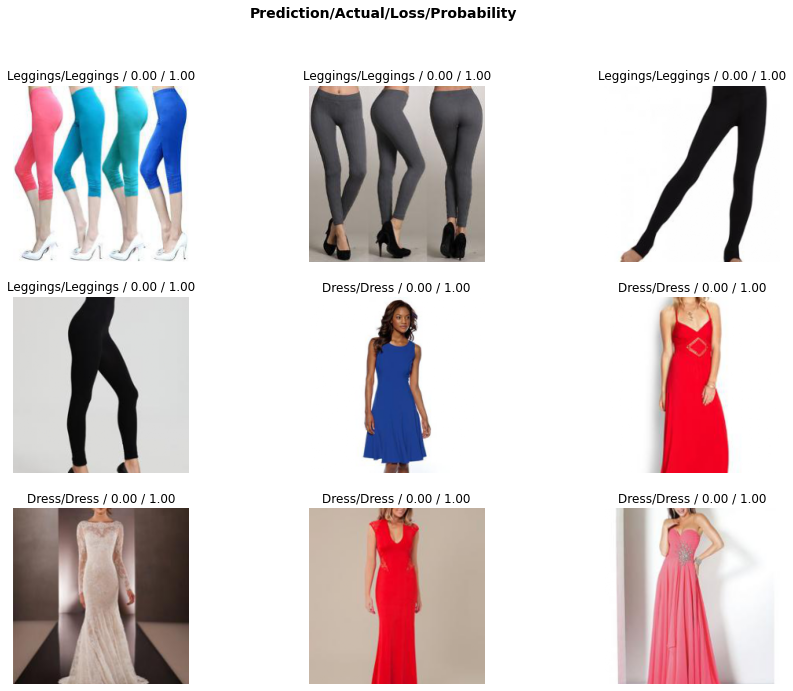

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

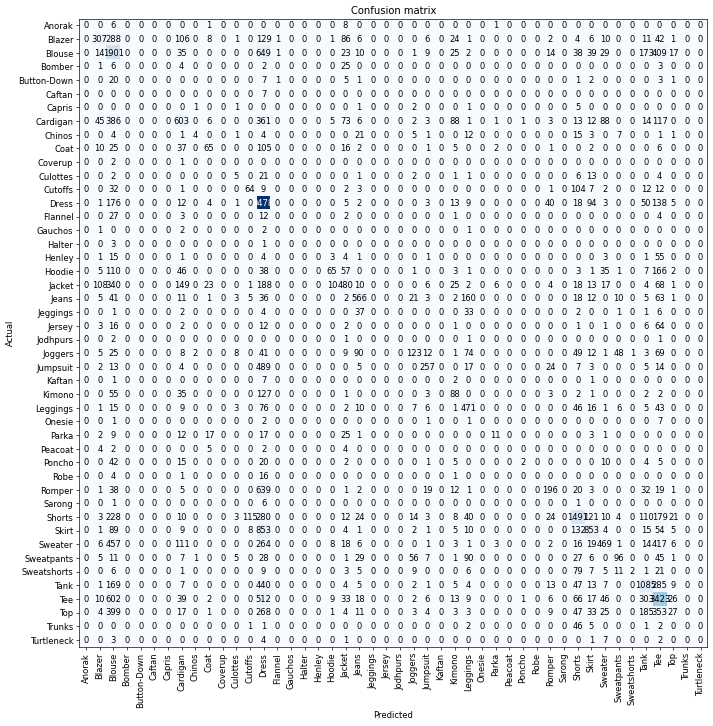

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# learner.model.module

In [ ]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

,img_path,label,label_id,embeddings
0,./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,2,"[8.748438835144043, -4.080455303192139, 20.268..."
1,./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,2,"[7.044660568237305, 22.47146224975586, 15.0255..."
2,./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,2,"[-9.8770170211792, -7.360237121582031, 23.2154..."
3,./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,Blouse,2,"[6.0021162033081055, -16.64525604248047, 18.16..."
4,./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,Blouse,2,"[17.563854217529297, -3.617328643798828, 9.675..."
...,...,...,...,...
249217,./img/Paisley_Print_Babydoll_Dress/img_0000003...,Dress,13,"[0.33774998784065247, -29.230464935302734, -34..."
249218,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[8.342782974243164, -10.599976539611816, -19.8..."
249219,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[12.787018775939941, -34.563079833984375, -19...."
249220,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[16.8948917388916, -17.189908981323242, -4.677..."


# Use Approximate Nearest Neighbors to obtain most similar images

In [ ]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 


# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return data_df_ouput.iloc[similar_img_ids[1:]] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [ ]:
# more tree = better approximation
ntree = 100
# ntree = 150

#"angular", "euclidean", "manhattan", "hamming", or "dot" 
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

## Embeddings Centroid Detection

In [ ]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

110051


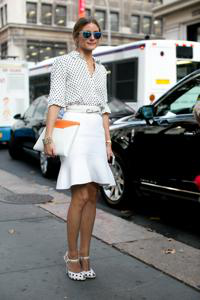

In [ ]:
# image explorer 
img_index = np.random.randint(len(data_df_ouput),size=1)[0]
print(img_index)
open_image(data_df_ouput.iloc[img_index, 0])

In [ ]:
image_map = { 'urban':[50374, 226654, 60186, 56384, 46254, 212771, 118639, 33918, 228773, 46332, 118173, 146836],
             'urban lifestyle':[50374, 226654, 60186, 56384, 46254, 212771, 118639, 33918, 228773, 46332, 118173, 146836],
             'flowers':[171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155],
             'flower':[171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155],
             'flower dress':[171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155],
             'flowers dress':[171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155],
             'shorts': [109938, 106385, 113703, 98666, 113467, 120667, 20840, 8450, 142843, 238607, 124505,222671],
             'jeans': [101040,101041,101042,101043,101044,101044,101055,101045,101050,101053,101051,101041],
             'cardigan': [25327,25328,25329,25420,25410,25440,25430,25421,25422,25423],
             'tee': [23753,23754,23755,23893,228530,228531,228532,228528,228525],
             'jacket':[25487,25488,25489,25491,22851,228520,22834,228342],
             'blazer':[539,540,213673,543,541,213674,213675,213676,545,213680],
             'hoodie': [24551,24552,24554,24555,228309,228311,24557,24560,24569],
             'top':[23825,23826,23927,23828,23829,228534,228535,228535,228536,228537,228537]
             }

tags = sorted(list(image_map.keys()))

In [ ]:
print("Choose any tag in the given list:")
print(tags)
query = str(input()).lower()

outfit_img_ids = image_map[query]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

In [ ]:
show_similar_images(outfits_selected, fig_size=[15,15])

In [ ]:
show_similar_images(similar_images_df, fig_size=[20,20])

In [ ]:
# data_df_ouput.loc[data_df_ouput['label'] == 'Top']